# Probit Example for Moment Sensitivity

This example is a replication of the probit model in [Honoré, Jørgensen & de Paula (2020)](https://papers.ssrn.com/abstract=3518640), Section 3.1.

Through this example, we will show you how to set up the `params`, how to use the`optimize` functions, and how to calculate the local `moment_sensitivity` measurements for your own model. 

In [16]:
import numpy as np
import pandas as pd
from scipy import stats

from estimagic import minimize
from estimagic.config import TEST_DIR
from estimagic.sensitivity.moment_sensitivity import moment_sensitivity

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

from estimagic.visualization.sensitivity_plot import moment_sensitivity_plot

sns.set(style="whitegrid")

## Input Data

First, we should create the index for `params`. Here, we only have one set of params, `beta`. 

In [18]:
params_index = [["beta"], ["intercept", "x1", "x2"]]
params_index = pd.MultiIndex.from_product(params_index, names=["type", "name"])
print(params_index)

MultiIndex([('beta', 'intercept'),
            ('beta',        'x1'),
            ('beta',        'x2')],
           names=['type', 'name'])


Now read the data.

In [19]:
data = pd.read_csv(TEST_DIR / "sensitivity" / "sensitivity_probit_example_data.csv")
y = data[["y"]]
y.head()

,y
0,1
1,1
2,0
3,0
4,1


In [20]:
x = data[["intercept", "x1", "x2"]]
x.head()

,intercept,x1,x2
0,1.0,2.967340,0.710528
1,1.0,-0.473715,-1.194718
2,1.0,-1.101197,-1.170433
3,1.0,-1.183257,-1.812715
4,1.0,-2.391786,-0.294773


## Calculate the Moments

In [21]:
def calc_moments_value(params, x, y, estimate_y=True):
    """This is the func2 in sensitivity module.

    Args:
        params (pd.DataFrame): see :ref:`params`
        x (pd.DataFrame)
        y (pd.DataFrame)
        estimate_y (boolean): use estimated y_star

    Return:
        mom_value (pd.DataFrame): sample value of moments
    """

    if estimate_y == True:
        y_estimated = x.to_numpy() @ (params["value"].to_numpy())
    else:
        y_estimated = y.copy(deep=True)

    x_np = x.T.to_numpy()

    residual = y.T.to_numpy() - stats.norm.cdf(y_estimated)
    mom_value = []

    # loop through all x

    length = len(x_np)

    for i in range(length):
        for j in range(i, length):
            moment = residual * x_np[i] * x_np[j]
            mom_value.append(moment)

    mom_value = np.stack(mom_value, axis=1)[0]
    mom_value = pd.DataFrame(data=mom_value)

    return mom_value

In [22]:
def calc_moments_expectation(params, x, y, estimate_y=True):
    """This is the func1 in sensitivity module.

    Args:
        params (pd.DataFrame): see :ref:`params`
        x (pd.DataFrame)
        y (pd.DataFrame)
        estimate_y (boolean): use estimated y_star

    Return:
        moments (np.array): expectation of moments
    """

    mom_value = calc_moments_value(params, x, y, estimate_y)

    moments = mom_value.mean(axis=1)

    # do not use pd.DataFrame since jacobian: extrapolation=False
    # moments = pd.DataFrame(data=moments,
    #                        columns=["moments"])

    return moments

## Criterion Function & Estimation

This is the criterion function:

In [23]:
def criterion_func(params, x, y, weight_matrix):
    """
    Args:
        params (pd.DataFrame)
        x (pd.DataFrame)
        y (pd.DataFrame)
        weight_matrix (np.array)

    Return:
        criterion (float)
    """

    moments = calc_moments_expectation(params, x, y, estimate_y=True).to_numpy()

    criterion = moments.T @ weight_matrix @ moments
    criterion = criterion.item()

    return criterion

Give the initial arguments:

In [24]:
I_matrix = np.identity(6)

params_init = pd.DataFrame(
    data=np.full((3, 1), 0.5), index=params_index, columns=["value"]
)
params_init

value
type name            
beta intercept    0.5
     x1           0.5
     x2           0.5

Now, we can estimate the `params` using identity matrix as the weight matrix:

In [25]:
estimation = minimize(
    criterion=criterion_func,
    params=params_init,
    criterion_kwargs={"x": x, "y": y, "weight_matrix": I_matrix},
    algorithm="scipy_lbfgsb",
)

In [26]:
params_estimated = estimation["solution_params"]
params_estimated

lower_bound  upper_bound     value
type name                                         
beta intercept         -inf          inf  0.612660
     x1                -inf          inf  0.651565
     x2                -inf          inf  0.574983

The true `beta`'s for this data are $1/\sqrt{3}\approx 0.57735$, so that looks ok for the small sample size.

## Sensitivity Measurements

Now, we can call the sensitivity function without specifying a weight matrix, in other words, using the optimal weight matrix.

In [27]:
sensitivity = moment_sensitivity(
    moment_func=calc_moments_expectation,
    moment_contributions_func=calc_moments_value,
    params=params_estimated,
    func1_kwargs={"x": x, "y": y},
    func2_kwargs={"x": x, "y": y},
    save_csv=False,
)

In [28]:
sensitivity

{'sensitivity_to_bias':                        0         1         2         3         4         5
 type name                                                                 
 beta intercept  4.489085  2.202841  2.869584  0.358391  1.561984  0.637328
      x1         0.856298  6.960270 -2.218056  1.374260 -2.160763 -0.087223
      x2         2.430235 -1.500809  7.776537 -0.994088  1.803432  0.208867,
 'fundamental_sensitivity_to_noise':                        0         1         2         3         4         5
 type name                                                                 
 beta intercept  1.207220  0.189112  0.304656  0.009398  0.051342  0.025313
      x1         0.029979  1.288544  0.124226  0.094304  0.067054  0.000324
      x2         0.237338  0.058885  1.500872  0.048501  0.045911  0.001824,
 'actual_sensitivity_to_noise':                        0         1         2         3         4         5
 type name                                                              

## Visualization

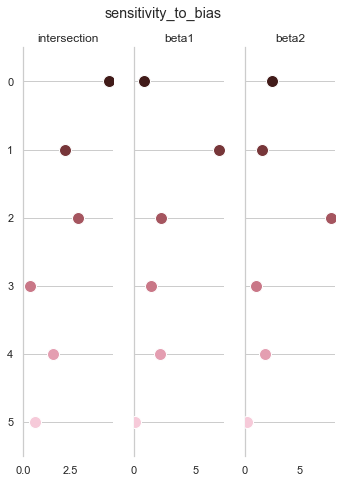

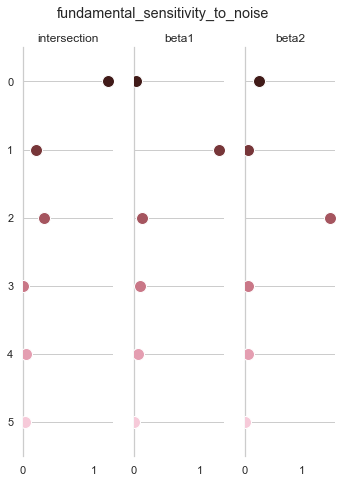

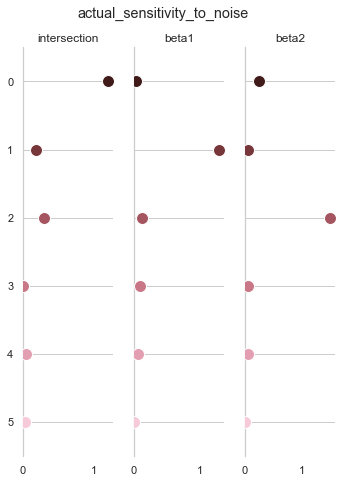

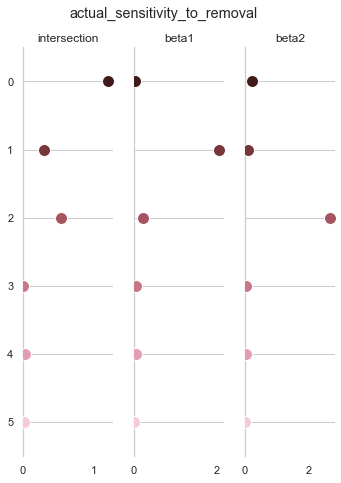

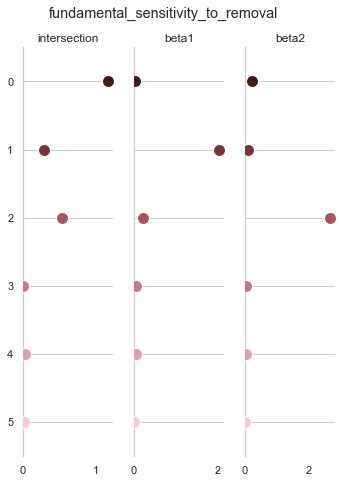

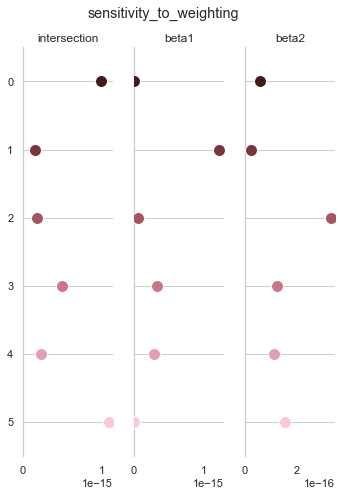

In [29]:
moment_sensitivity_plot(sensitivity)